# June 24,27, 2022: Inter-subject Functional Correlation matrices

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import zscore

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
 

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

num_rois = 85
args.roi_idxs = np.arange(num_rois)

In [3]:
# with open(f"{proj_dir}/data/max/exploratory_data_roi_indices.pkl", 'rb') as f:
#     roi_idxs = pickle.load(f)

In [4]:
def get_isfc_matrix(x_s):
    isfc = []
    for idx_subj in np.arange(x_s.shape[0]):
        x_subj = x_s[idx_subj]

        mask = np.ones(x_s.shape[0], dtype=bool)
        mask[idx_subj] = False
        x_others = np.mean(x_s[mask], axis=0)

        r = x_subj.shape[1]
        # fisher's r-to-z transformation
        corr_mat = np.arctanh(np.corrcoef(x_subj, x_others, rowvar=False)[:r, r:])
        corr_mat = (corr_mat + corr_mat.T) / 2

        isfc.append(corr_mat)
    return np.mean(np.stack(isfc, axis=0), axis=0)

## `threat` vs `safe`

In [5]:
with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

min_len = {}
for label in args.LABELS:
    lengths = []
    for idx_subj in np.arange(len(X[label])):
        lengths.append(X[label][idx_subj].shape[0])
    min_len[label] = min(lengths)
min_len = min(min_len.values())

for label in args.LABELS:
    for idx_subj in np.arange(len(X[label])):
        x = X[label][idx_subj][:min_len, :]
        x = np.reshape(x, (x.shape[0]*x.shape[1], x.shape[2]))
        X[label][idx_subj] = zscore(x, axis=0)
    X[label] = np.stack(X[label], axis=0)

isfc = { # inter-subject (functional) correlation
    0: [],
    1: [],
}
for label in args.LABELS:
    isfc[label] = get_isfc_matrix(X[label])

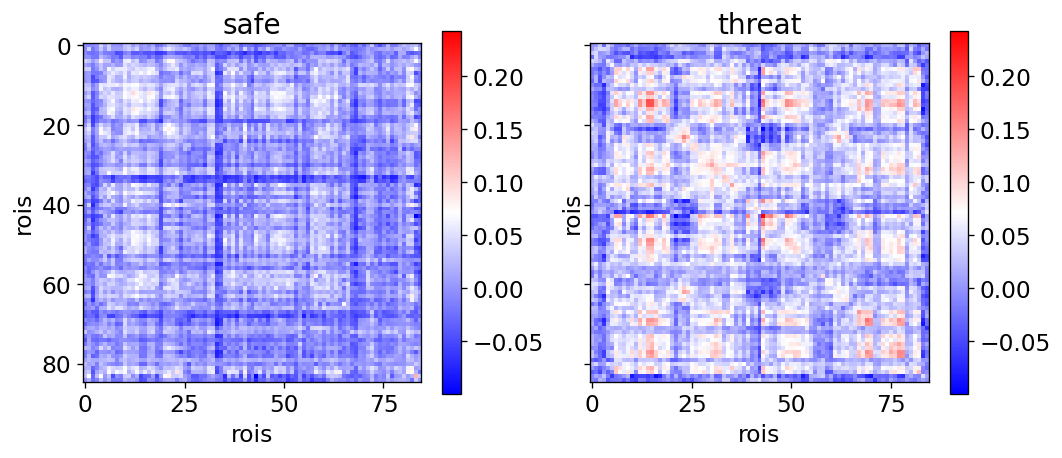

In [6]:
nrows, ncols = 1, len(args.LABELS)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

vmin, vmax = [], []
for label in args.LABELS:
    vmin.append(np.min(isfc[label]))
    vmax.append(np.max(isfc[label]))
vmin, vmax = min(vmin), max(vmax)

for label in args.LABELS:
    ax = axs[label]
    im = ax.imshow(
        isfc[label][args.roi_idxs][args.roi_idxs], 
        cmap='bwr', vmin=vmin, vmax=vmax)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"{args.names[label]}")
    ax.set_ylabel(f"rois")
    ax.set_xlabel(f"rois")

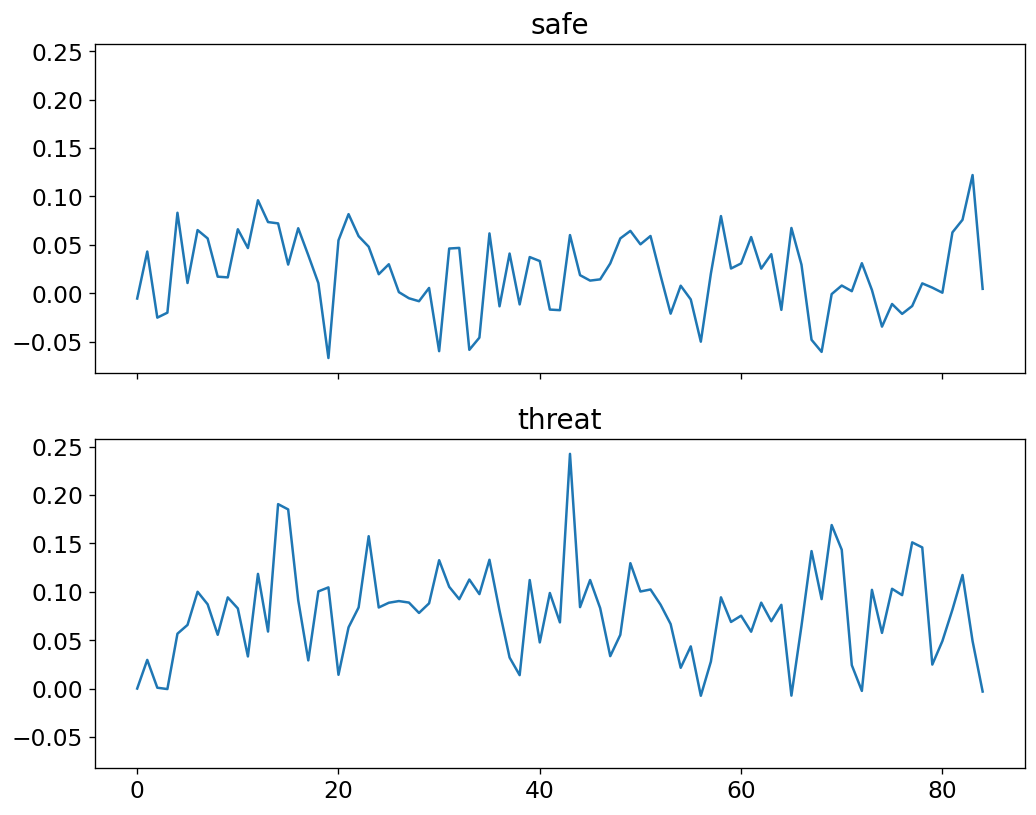

In [7]:
nrows, ncols = len(args.LABELS), 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(10*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)
for label in args.LABELS:
    ax = axs[label]
    ax.plot(np.diag(isfc[label]), label='mean')
    ax.set_title(f"{args.names[label]}")

## `early` vs `late` periods
within `threat` and `safe` conditions

In [8]:
with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

# time periods
TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+TR, TR) // TR
LATE = np.arange(10.0, 16.25+TR, TR) // TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
print(EARLY, LATE)
PERIODS = {'early':EARLY, 'late':LATE}

[2 3 4 5 6 7] [ 8  9 10 11 12 13]


In [9]:
args.PERIODS = ['early', 'late']
PERIOD = {'early':EARLY, 'late':LATE}

# create time series collector
ts = {}
for cond in args.names:
    ts[cond] = {}
    for period in args.PERIODS:
        ts[cond][period] = []

# fill in time series
for label, cond in zip(args.LABELS, args.names):
    for period in args.PERIODS:
        
        for idx_subj in np.arange(len(X[label])):
            
            x = zscore(X[label][idx_subj][:, PERIOD[period], :], axis=0)
            x = np.reshape(x, (x.shape[0]*x.shape[1], x.shape[2]))
            ts[cond][period].append(x)

# find minimum number of time points
min_tp = []
for label, cond in zip(args.LABELS, args.names):
    for period in args.PERIODS:

        for idx_subj in np.arange(len(ts[cond][period])):
            min_tp.append(ts[cond][period][idx_subj].shape[0])
min_tp = min(min_tp)

for label, cond in zip(args.LABELS, args.names):
    for period in args.PERIODS:

        for idx_subj in np.arange(len(ts[cond][period])):
            ts[cond][period][idx_subj] = ts[cond][period][idx_subj][:min_tp, :]
        
        ts[cond][period] = np.stack(ts[cond][period], axis=0)
        # print(ts[cond][period].shape)

# isfc
isfc = {}
for cond in args.names:
    isfc[cond] = {}
    for period in args.PERIODS:
        isfc[cond][period] = []

for label, cond in zip(args.LABELS, args.names):
    for period in args.PERIODS:
        isfc[cond][period] = get_isfc_matrix(ts[cond][period])

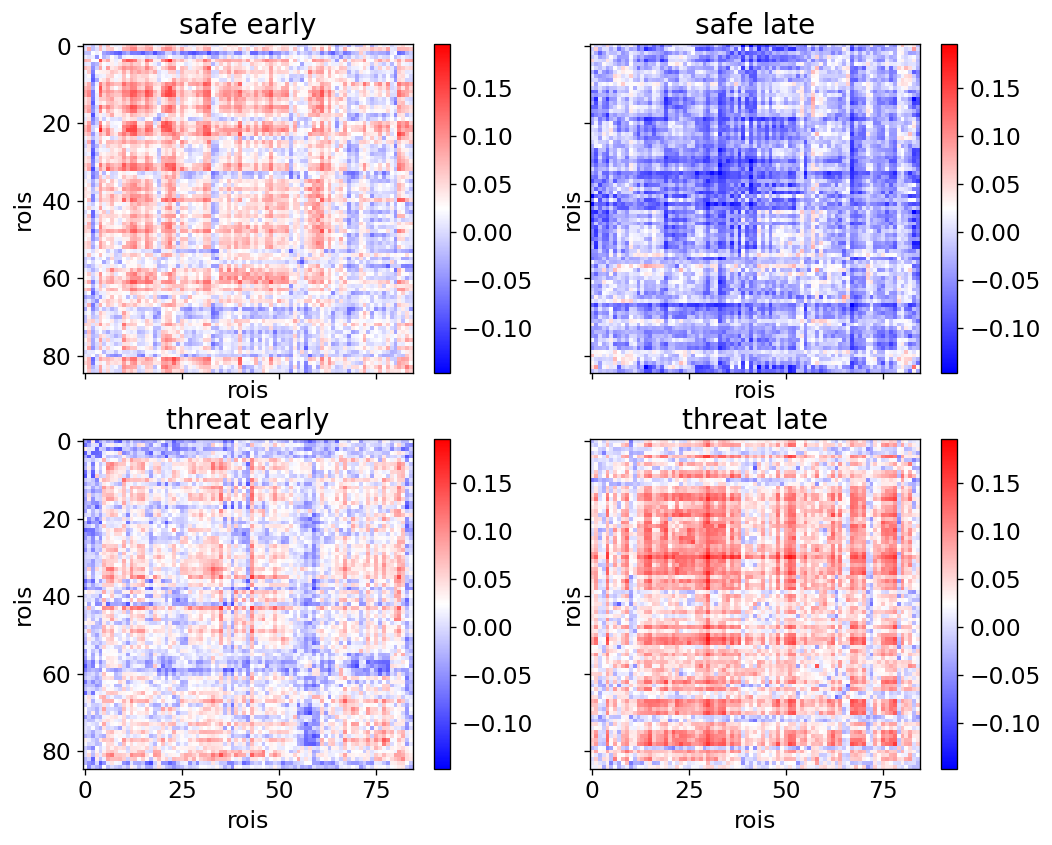

In [10]:
nrows, ncols = len(args.LABELS), len(args.PERIODS)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

vmin, vmax = [], []
for label, cond in zip(args.LABELS, args.names):
    for idx_period, period in enumerate(args.PERIODS):
        vmin.append(np.min(isfc[cond][period]))
        vmax.append(np.max(isfc[cond][period]))
vmin, vmax = min(vmin), max(vmax)

for label, cond in zip(args.LABELS, args.names):
    for idx_period, period in enumerate(args.PERIODS):
        ax = axs[label][idx_period]
        im = ax.imshow(
            isfc[cond][period][args.roi_idxs][args.roi_idxs], 
            cmap='bwr', vmin=vmin, vmax=vmax,) 
        cbar = ax.figure.colorbar(im, ax=ax)
        
        ax.set_title(f"{cond} {period}")
        ax.set_ylabel(f"rois")
        ax.set_xlabel(f"rois")